<a id='s3'></a>
## TREE COVER LOSS WIDGET 

The UMD/Hansen Tree cover loss widget should be a bar chart, with time as the x-axis, and loss (ha) as the y-axis, on hover it should show the year, ha loss, and % loss relative to 2000 tree cover extent *for the data table of interest*.

** Notes ** 

* Loss data tables have loss units in both area (ha) and emissions (t co2/ha). The emissions units will only be used in the loss widget to add contextual info to the dynamic sentence.

* It is probably best to always request the full time period of data from the table, and then subset it client-side, as we will always need to know the last year of loss to construct the dynamic sentence.

* In settings, the users should be able to change the data sources, when they do you will need to query different data tables both for calculating loss and extent (to calculate relative loss):
    - All region (default) view: gadm28 table
    - all other data tables currently created should be selectable too
    
*more info - not needed for front-end devs*
- for refrence in testing adm0 = BRA, adm1 = 12, adm2 = 1434 is Mato Grosso, Cáceres


** WHen plantations are selected the user should see a stacked bar chart  from 2013 onwards **
More details of this to follow below.


# Global Loss

Stacked bars from top 5 countries + rest.

Note, the top 5 countries are selected by looking at the countries with the most deforestation in the user selected year range (which means, for example, that the \#1 country may not always have the most loss in a given year)

In [1]:
#Import Global Metadata etc

%run '0.Importable_Globals.ipynb'

In [4]:
def global_extent_queries(p_name, year, adm0, adm1=None, adm2 = None, threshold=30):
    if adm2:
        print('Request for adm2 area')
        sql = (f"SELECT SUM({year}) as value, "
               f"SUM(area_gadm28) as total_area "
               f"FROM data "
               f"WHERE iso = '{adm0}' "
               f"AND adm1 = {adm1} "
               f"AND adm2 = {adm2} "
               "AND thresh = {threshold} "
               f"AND polyname = '{p_name}'")
        return sql
    elif adm1:
        print('Request for  adm1 area')
        sql = (f"SELECT SUM({year}) as value, "
               f"SUM(area_gadm28) as total_area "
               f"FROM data "
               f"WHERE iso = '{adm0}' "
               f"AND adm1 = {adm1} "
               f"AND thresh = {threshold} "
               f"AND polyname = '{p_name}'")
        return sql
    if adm0:
        print('Request for  adm0 area')
        sql = (f"SELECT SUM({year}) as value, "
               f"SUM(area_gadm28) as total_area "
               f"FROM data "
               f"WHERE iso = '{adm0}' "
               f"AND thresh = {threshold} "
               f"AND polyname = '{p_name}'")
    else:
        print('Request for Global area')
        sql = (f"SELECT SUM({year}) as value, "
               f"SUM(area_gadm28) as total_area "
               f"FROM data "
               f"WHERE thresh = {threshold} "
               f"AND polyname = '{p_name}'")
        return sql

In [13]:
def global_loss_queries(p_name, adm0, adm1=None, adm2=None, threshold=30):
    if adm2:
        print(f'Request for adm2 area')
        sql = (f"SELECT polyname, year_data.year as year, "
               f"SUM(year_data.area_loss) as area, "
               f"SUM(year_data.emissions) as emissions "
               f"FROM data "
               f"WHERE polyname = '{p_name}' "
               f"AND iso = '{adm0}' "
               f"AND adm1 = {adm1} "
               f"AND adm2 = {adm2} "
               f"AND thresh= {threshold} "
               f"GROUP BY polyname, iso, nested(year_data.year)")
        return sql
    elif adm1:
        print('Request for  adm1 area')
        sql = (f"SELECT polyname, year_data.year as year, "
               f"SUM(year_data.area_loss) as area, "
               f"SUM(year_data.emissions) as emissions "
               f"FROM data "
               f"WHERE polyname = '{p_name}' "
               f"AND iso = '{adm0}' "
               f"AND adm1 = {adm1} "
               f"AND thresh= {threshold} "
               f"GROUP BY polyname, iso, nested(year_data.year)")
        return sql
    elif adm0:
        print('Request for  adm0 area')
        sql = (f"SELECT polyname, year_data.year as year, "
               f"SUM(year_data.area_loss) as area, "
               f"SUM(year_data.emissions) as emissions "
               f"FROM data "
               f"WHERE polyname = '{p_name}' " 
               f"AND iso = '{adm0}' "
               f"AND thresh= {threshold} "
               f"GROUP BY polyname, iso, nested(year_data.year)")
    else:
        print('Request for  Global area')
        sql = (f"SELECT polyname, year_data.year as year, "
               f"SUM(year_data.area_loss) as area, "
               f"SUM(year_data.emissions) as emissions "
               f"FROM data "
               f"WHERE polyname = '{p_name}' " 
               f"AND thresh= {threshold} "
               f"GROUP BY polyname, iso, nested(year_data.year)")

        return sql



In [122]:
# Variables

adm0 = None
adm1 = None
adm2 = None

threshold=30
extent_year = 2000     #extent data (2000 hardcoded)

start=2002
end=2012
location = "All Region"

tags = ["forest_change", "land_cover", "conservation", "people", "land_use"]
selectable_polynames = ['gadm28',
                        'bra_biomes',
                        'mining',
                        'wdpa',
                        'primary_forest',
                        'ifl_2013']

In [176]:
# First, get the extent of tree cover over your area of interest (to work out relative loss)
sql = global_extent_queries(p_name=polynames[location], year=extent_year_dict[extent_year],
                     adm0=adm0, adm1=adm1, adm2=adm2, threshold=threshold)    
print(sql) # loss query
properties = {"sql": sql}
r = requests.get(url, params = properties)
print(r.url)
print(f'Status: {r.status_code}')
pprint(r.json())

y2000extent = r.json().get('data')[0].get('value')

Request for Global area
SELECT SUM(area_extent_2000) as value, SUM(area_gadm28) as total_area FROM data WHERE thresh = 30 AND polyname = 'gadm28'
https://production-api.globalforestwatch.org/v1/query/499682b1-3174-493f-ba1a-368b4636708e?sql=SELECT+SUM%28area_extent_2000%29+as+value%2C+SUM%28area_gadm28%29+as+total_area+FROM+data+WHERE+thresh+%3D+30+AND+polyname+%3D+%27gadm28%27
Status: 200
{'data': [{'total_area': 12882338532.03318, 'value': 3992819698.666184}],
 'meta': {'cloneUrl': {'body': {'dataset': {'application': ['your', 'apps'],
                                            'datasetUrl': '/v1/query/499682b1-3174-493f-ba1a-368b4636708e?sql=SELECT%20SUM%28area_extent_2000%29%20as%20value%2C%20SUM%28area_gadm28%29%20as%20total_area%20FROM%20data%20WHERE%20thresh%20%3D%2030%20AND%20polyname%20%3D%20%27gadm28%27'}},
                       'http_method': 'POST',
                       'url': '/v1/dataset/499682b1-3174-493f-ba1a-368b4636708e/clone'}}}


In [124]:
#ds = '499682b1-3174-493f-ba1a-368b4636708e'
url = f"https://production-api.globalforestwatch.org/v1/query/{ds}"

print(adm0)

# Next, get the loss data grouped by year
sql = global_loss_queries(p_name=polynames[location], adm0=adm0, 
                   adm1=adm1, adm2=adm2, threshold=threshold)  

print(sql) # loss query
properties = {"sql": sql}
r = requests.get(url, params = properties)
print(r.url)
print(f'Status: {r.status_code}')
loss_data = r.json().get('data')

None
Request for  Global area
SELECT polyname, year_data.year as year, SUM(year_data.area_loss) as area, SUM(year_data.emissions) as emissions FROM data WHERE polyname = 'gadm28' AND thresh= 30 GROUP BY polyname, iso, nested(year_data.year)
https://production-api.globalforestwatch.org/v1/query/499682b1-3174-493f-ba1a-368b4636708e?sql=SELECT+polyname%2C+year_data.year+as+year%2C+SUM%28year_data.area_loss%29+as+area%2C+SUM%28year_data.emissions%29+as+emissions+FROM+data+WHERE+polyname+%3D+%27gadm28%27+AND+thresh%3D+30+GROUP+BY+polyname%2C+iso%2C+nested%28year_data.year%29
Status: 200


In [181]:
total_loss = sum([d.get('area',0) for d in loss_data if d.get('year') >= start and d.get('year') <= end])

In [191]:
loss_data[0:3]

[{'area': 2746361.4890696183,
  'emissions': 451665397.0006001,
  'iso': 'BRA',
  'polyname': 'gadm28',
  'year': 2001},
 {'area': 3507049.430043675,
  'emissions': 599107237.3975263,
  'iso': 'BRA',
  'polyname': 'gadm28',
  'year': 2002},
 {'area': 3248526.7289099023,
  'emissions': 540574861.4785872,
  'iso': 'BRA',
  'polyname': 'gadm28',
  'year': 2003}]

In [192]:
isos = {}

for d in loss_data:
    if d.get('iso') not in isos:
        isos[d.get('iso')] = 0
    if d.get('year') >= start and d.get('year') <= end:
        isos[d.get('iso')] += d.get('area', 0)
    

In [193]:
## Everything else falls into 'other' data in stacked bars
top_losses = sorted(isos.items(), key=lambda x: x[1], reverse=True)[0:5]

In [194]:
top_isos = [i[0] for i in top_losses]
top_isos

['BRA', 'RUS', 'CAN', 'USA', 'IDN']

In [195]:
other_loss = list(filter(lambda x: x.get('iso') not in top_loss_isos, loss_data))

In [196]:
returned_data = []
for iso in top_isos:
    data = list(filter(lambda x: x.get('iso') == iso, loss_data))
    d = {}
    for row in data:
        tmp_yr = float(row.get('year'))
        if tmp_yr >= start and tmp_yr <= end:
            try:
                tmp_area = float(row.get('area'))
            except:
                tmp_area = None

            try:
                tmp_area_pcnt = (tmp_area / y2000extent) * 100
            except:
                tmp_area_pcnt = None

            try:
                tmp_emiss = float(row.get('emissions'))
            except:
                tmp_emiss = None

            d[int(tmp_yr)] = {'area_ha': tmp_area,
                                  'area_%': tmp_area_pcnt,
                                  'emissions': tmp_emiss,
                              'iso': iso
                                   }
    returned_data.append(d)

In [197]:
returned_data

[{2002: {'area_%': 0.08783390422600894,
   'area_ha': 3507049.430043675,
   'emissions': 599107237.3975263,
   'iso': 'BRA'},
  2003: {'area_%': 0.08135921414120163,
   'area_ha': 3248526.7289099023,
   'emissions': 540574861.4785872,
   'iso': 'BRA'},
  2004: {'area_%': 0.0963923013734369,
   'area_ha': 3848770.7972362638,
   'emissions': 676408980.2036796,
   'iso': 'BRA'},
  2005: {'area_%': 0.0873208153074127,
   'area_ha': 3486562.714630291,
   'emissions': 644553412.0320137,
   'iso': 'BRA'},
  2006: {'area_%': 0.07204945093361238,
   'area_ha': 2876804.669658102,
   'emissions': 513807720.2924354,
   'iso': 'BRA'},
  2007: {'area_%': 0.06566337678131799,
   'area_ha': 2621820.242933862,
   'emissions': 437504684.6362488,
   'iso': 'BRA'},
  2008: {'area_%': 0.06121759510166215,
   'area_ha': 2444308.1962688714,
   'emissions': 421136841.3216598,
   'iso': 'BRA'},
  2009: {'area_%': 0.0455292593146639,
   'area_ha': 1817901.2345727086,
   'emissions': 309401955.17921805,
   'iso'

In [198]:
other = {}
for year in range(start, end+1):
    data = list(filter(lambda x: x.get('year') == year, other_loss))
    
    total_area = 0
    total_emissions = 0
    
    for d in data:
        total_area += d.get('area', 0)
        total_emissions += d.get('emissions', 0)
    
    other[year] = {'area_ha': total_area,
               'area_%': 100 * total_area / y2000extent,
               'emissions': total_emissions,
                'iso': 'OTH'
               }
    
returned_data.append(other)

In [200]:
vizz_data=[]
for data in returned_data:
    loss = []
    for val in data.values():
        if val.get('area_ha'):
            loss.append(val.get('area_ha')/1e6) # in Mha
        else:
            loss.append(0)
    vizz_data.append(loss)
    
len(vizz_data[5])

11

In [201]:
bottom_5 = vizz_data[5]
bottom_4 = [vizz_data[4][j]+bottom_5[j] for j in range(len(vizz_data[0]))]
bottom_3 = [vizz_data[3][j]+bottom_4[j] for j in range(len(vizz_data[0]))]
bottom_2 = [vizz_data[2][j]+bottom_3[j] for j in range(len(vizz_data[0]))]
bottom_1 = [vizz_data[1][j]+bottom_2[j] for j in range(len(vizz_data[0]))]

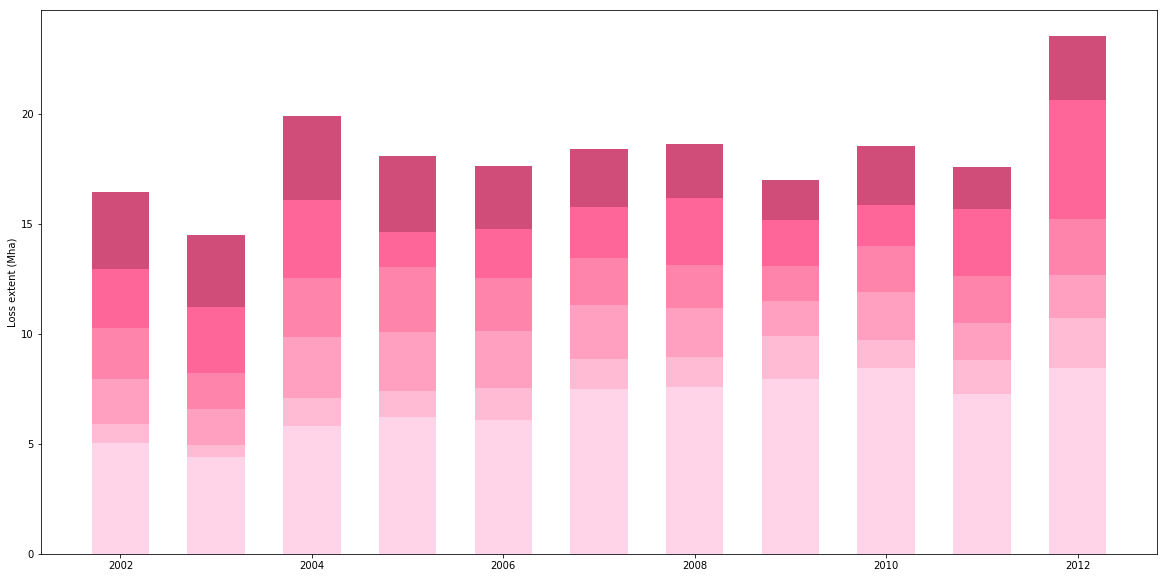

In [202]:
years = returned_data[0].keys()
width = 0.6

fig, ax = plt.subplots(figsize=(20,10))

rects1 = ax.bar(years, vizz_data[5], width, color='#FFD4E9')
rects2 = ax.bar(years, vizz_data[4], width, bottom=bottom_5, color='#FFBAD4')
rects3 = ax.bar(years, vizz_data[3], width, bottom=bottom_4, color='#FFA0C0')
rects4 = ax.bar(years, vizz_data[2], width, bottom=bottom_3, color='#FF84AC')
rects5 = ax.bar(years, vizz_data[1], width, bottom=bottom_2, color='#FE6598')
rects6 = ax.bar(years, vizz_data[0], width, bottom=bottom_1, color='#D04D7A')

# add some text for labels, title and axes ticks
ax.set_ylabel('Loss extent (Mha)')
plt.show()

In [ ]:
#Note, display country, area and % on hover.

# Dynamic Sentence

- Global total is X
- equal to % of total extent

In [190]:
print(f"Between {start} and {end} there was a total of {int(total_loss)}Ha of tree cover loss globally, ", end="")
print(f"equivalent to around {round(100 * total_loss / y2000extent, 1)}% of the global tree cover in 2000.", end="")

Between 2002 and 2012 there was a total of 200235350Ha of tree cover loss globally, equivalent to around 5.0% of the global tree cover in 2000.